In [1]:
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from tqdm import tqdm
from matplotlib import pyplot as plt
from scipy import signal

In [4]:
data_files = glob.glob("*.log")
print(len(data_files), data_files)

13 ['matt1-stair-60r.log', 'matt2-2r.log', 'matt2-standr.log', 'nick2-25l.log', 'abby2-2r.log', 'matt2-21l.log', 'matt2-sitl.log', 'abby1-stair-48r.log', 'matt2-sitr.log', 'matt1-stair-66l.log', 'abby1-stair-72l.log', 'abby2-22l.log', 'nick2-25r.log']


matt1-stair-60r.log


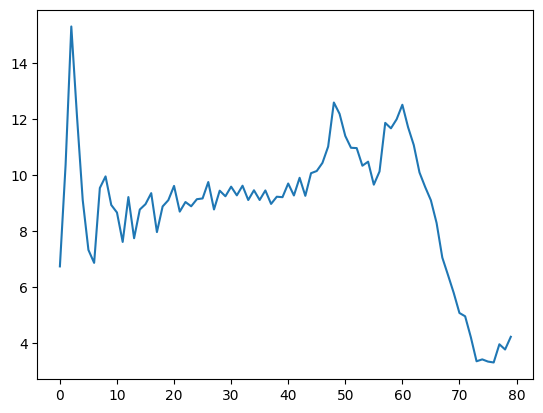

(24000, 9)
(1197, 80, 9)
matt2-2r.log


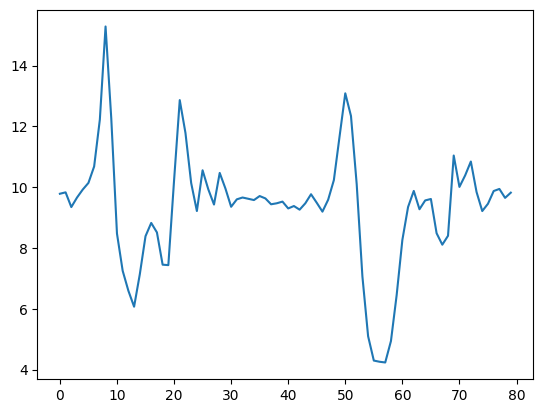

(18235, 9)
(905, 80, 9)
matt2-standr.log


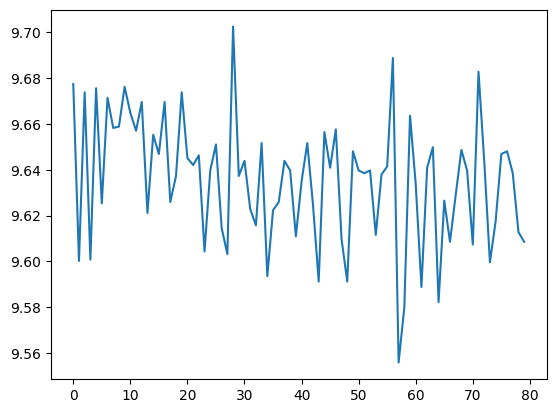

(24000, 9)
(1197, 80, 9)
nick2-25l.log


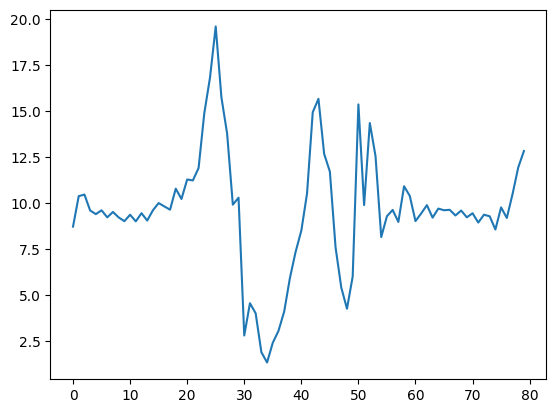

(24000, 9)
(1197, 80, 9)
abby2-2r.log


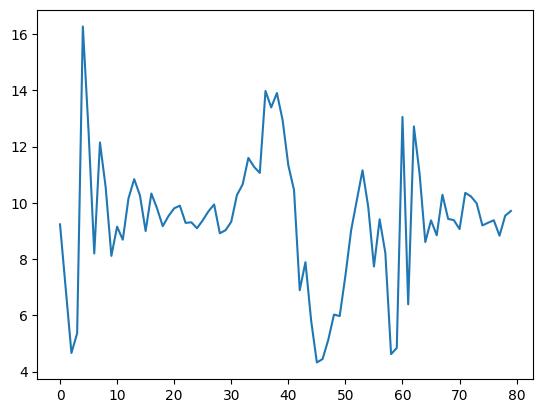

(24000, 9)
(1197, 80, 9)
matt2-21l.log


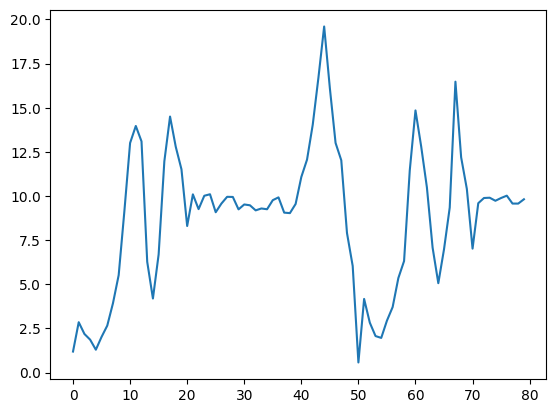

(24000, 9)
(1197, 80, 9)
matt2-sitl.log


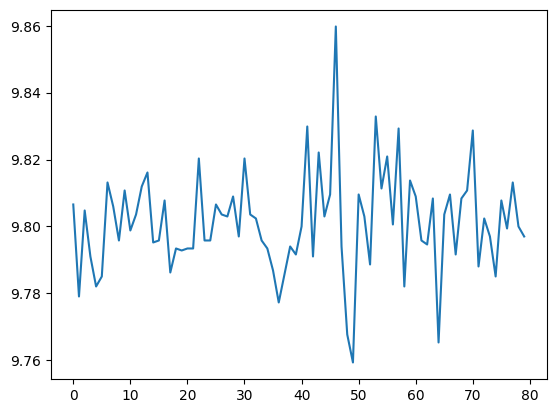

(24000, 9)
(1197, 80, 9)
abby1-stair-48r.log


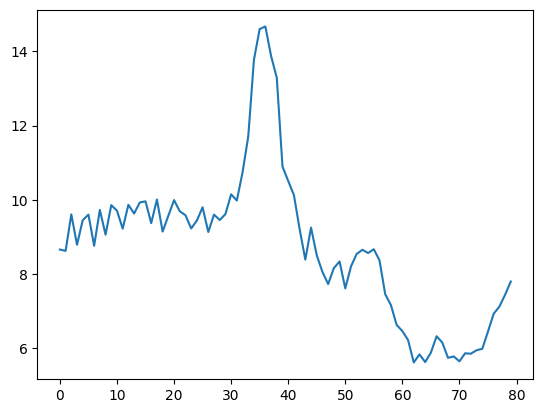

(24000, 9)
(1197, 80, 9)
matt2-sitr.log


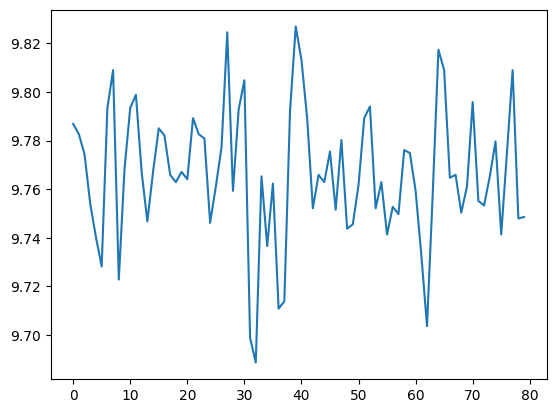

(24000, 9)
(1197, 80, 9)
matt1-stair-66l.log


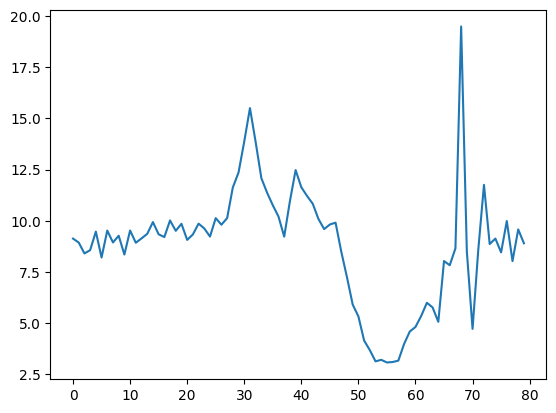

(24000, 9)
(1197, 80, 9)
abby1-stair-72l.log


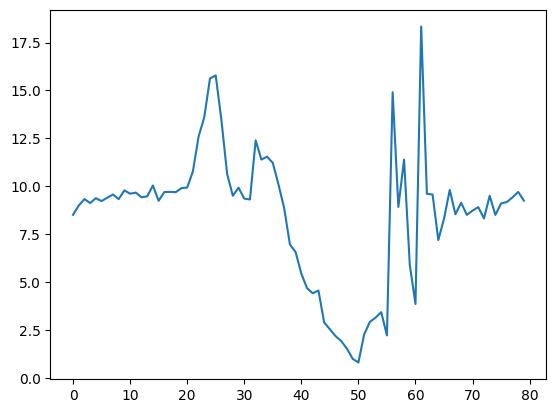

(24000, 9)
(1197, 80, 9)
abby2-22l.log


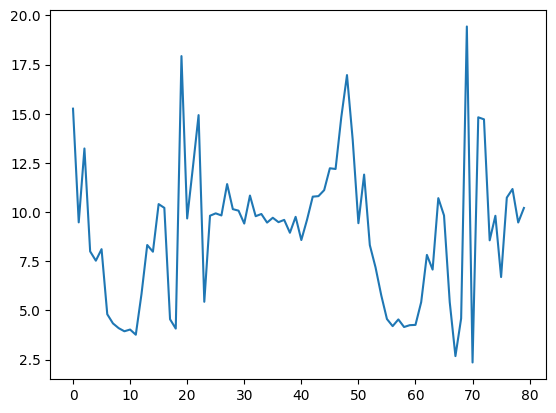

(24000, 9)
(1197, 80, 9)
nick2-25r.log


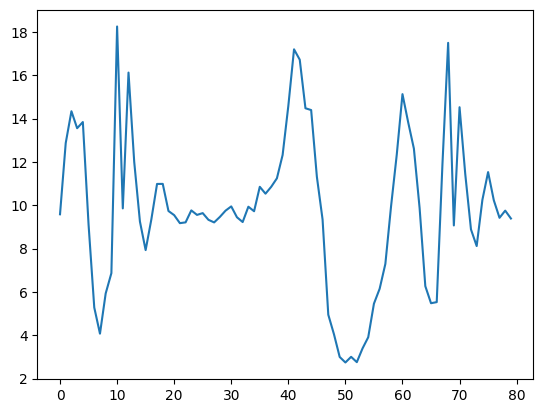

(24000, 9)
(1197, 80, 9)
13 13


In [30]:
WINDOW_SIZE = 80
WINDOW_STEP = 20

master = {}
phrase = "Acc X"
phrase2 = "Time taken by the task: 25 milliseconds"
phrase3 = "Time taken by the task: 24 milliseconds"
cols = ['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z', 'mag_x', 'mag_y', 'mag_z']

sample_rate = 1/0.025 # Hz
num_channels = 9
ten_minutes =round(10*60*num_channels*sample_rate) #mins*seconds/min*num_channels*samples/second+ 1(python index start 0)
i = 0

train_X = []
train_Y = []
test_X = []
test_Y = []

for file in data_files:
    print(file)
    
    data = []
    with open(file) as f:
        f = f.readlines()

    for line in f[1:]:
        # Want to start beginning with x-acceleration measurements so data is alligned properly
        if line[:-1] == phrase:
            start = True
        if phrase not in line and phrase2 not in line and phrase3 not in line and start:
            data.append(float(line[:-1]))
    
    data = data[:ten_minutes]
    data = np.array(data)
    data = data.reshape((-1,9))
    plt.figure()
    plt.plot(data[:80,0])
    plt.show()
    print(data.shape)

    # Split into non-overlapping windows
    # Don't use the last bit of data that doesn't fill a whole window
    n_windows = data.shape[0] // WINDOW_SIZE
    end = WINDOW_SIZE * n_windows
    data = data[:end,:]

    # Split into overlapping windows
    data = np.lib.stride_tricks.sliding_window_view(data, WINDOW_SIZE, axis=0)[::WINDOW_STEP]
    data = data.transpose(0,2,1)
    print(data.shape)
    train_X.append(data)
    
    # upstairs
    if i==0 or i ==7 or i==9 or i==10:
        train_Y.append(3*np.ones((data.shape[0])))
    # walking
    if i==1 or i==3 or i==4 or i==5 or i==11 or i==12:
        train_Y.append(2*np.ones((data.shape[0])))
    # standing
    if i==2:
        train_Y.append(np.ones((data.shape[0])))
    # sitting    
    if i==6 or i==8:
        train_Y.append(np.zeros((data.shape[0])))
        
    i += 1
    
print(len(train_X), len(train_Y))
    

In [24]:
num = 0
for i in range(len(train_X)):
    print(train_X[i].shape[0])
    num += train_X[i].shape[0]
print(num)

1197
905
1197
1197
1197
1197
1197
1197
1197
1197
1197
1197
1197
15269


In [40]:
sample_x = train_X[0][0,:,0]
x_stretch = signal.resample(sample_x, int(len(sample_x) * 1.1))
x_squeeze = signal.resample(sample_x, int(len(sample_x) * 0.9))
x_shrink = sample_x * 0.8
x_scaled = sample_x * 1.2

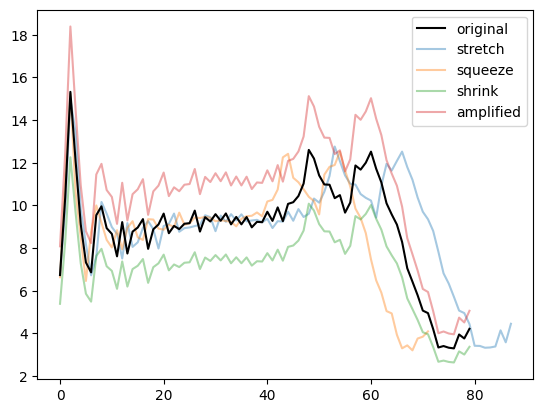

In [41]:
plt.plot(sample_x, label="original", zorder=4, c='k')
plt.plot(x_stretch, label="stretch", alpha=0.4)
plt.plot(x_squeeze, label="squeeze", alpha=0.4)
plt.plot(x_shrink, label="shrink", alpha=0.4)
plt.plot(x_scaled, label="amplified", alpha=0.4)
plt.legend()
plt.show()

In [ ]:
class IMUDataset(torch.utils.data.Dataset):
    def __init__(self, data_x, data_y):
        """
        Parameters:
        -----------
        data_x: np.ndarray of shape (num_samples, window_size, num_features) which contains data features for FoG
        data_y: np.ndarray of shape (num_samples, window_size) which contains binary labels for FoG
        """
        super().__init__()
        self.data_x = data_x
        self.data_y = data_y

    def __len__(self):
        return self.data_x.shape[0]

    def __getitem__(self, index):
        """Returns tuple of (data, label) at index"""
        inputs = self.data_x[index, :, :]
        labels = self.data_y[index, :]
        return inputs, labels


class IMUDataAugment:
    """
    Collate function to apply random time stretch/squeeze and signal shrink/scale
    Apply stretch/squeeze to the time dimension by resampling and truncating to out_samples
        The lower bound of stretch must satisfy (lb * len(input)) > out_samples
    """
    def __init__(self, out_samples=80, p=0.5, stretch=(0.8, 1.2), scale=(0.8, 1.2)):
        """
        Parameters:
        -----------
        p: float between [0, 1], probability of applying each the stretch and scale transform independently
        strech: tuple of float, upper and lower bound on time stretch factor
        scale: tuple of float, upper and lower bound on signal scale factor
        """
        self.p = p
        self.stretch = stretch
        self.scale = scale
        self.out_samples = out_samples
    
    def _reduce_labels(self, y):
        """If there is a 1 in the label, then return 1"""
        return np.any(y == 1, axis=-1).astype(int)

    def _random_crop(self, inputs, labels):
        """Apply a random crop of the signal of length self.out_samples to both inputs and labels"""
        n, d = inputs.shape
        max_offset = n - self.out_samples
        offset = np.random.choice(max_offset)
        inds = slice(offset, offset + self.out_samples)
        return inputs[inds, :], labels[inds]

    def __call__(self, data):
        """
        Parameters:
        -----------
        data: list of tuple of (inputs, labels) of length batch_size
            inputs: np.ndarray, dimensions (n_samples, n_channels), signal data
            labels: np.ndarray, dimensions (n_samples,), binary label vector for the signal data

        Returns:
        --------
        (inputs, labels): augmented signal data, reduced labels
        """
        x = []
        y = []
        for (inputs, labels) in data:
            n, d = inputs.shape
            assert (self.stretch[0] * n) >= self.out_samples, f"input size {n} must be greater than {int(self.out_samples / self.stretch[0])} to apply augmentation"

            # Randomly apply time stretch
            if np.random.binomial(1, self.p) != 0:
                lb, ub = self.stretch
                stretch = np.random.uniform(lb, ub)
                inputs = signal.resample(inputs, int(n * stretch), axis=0)  # Resample the time (n_samples) axis
            if np.random.binomial(1, self.p) != 0:
                lb, ub = self.scale
                scale = np.random.uniform(lb, ub)
                inputs = scale * inputs  # Scale all channels equally
            
            # Apply random crop to self.out_size on both inputs and labels
            inputs, labels = self._random_crop(inputs, labels)

            labels = self._reduce_labels(labels)
            x.append(inputs)
            y.append(labels)
        collated_inputs = torch.tensor(x, dtype=torch.float32)
        collated_labels = torch.tensor(y, dtype=torch.float32)
        return collated_inputs, collated_labels

In [ ]:
train_dataset = IMUDataset(train_X, train_Y)
test_dataset = IMUDataset(test_X, test_Y)

augment_fn = IMUDataAugment(out_samples=80)
test_augment = IMUDataAugment(out_samples=80, p=0)

BATCH_SIZE = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=augment_fn, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=test_augment)

In [ ]:
def train(model, dataloader, optimizer, criterion, epoch, logging_steps=20, device=None):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
    model.train()
    total_loss = 0
    correct = 0
    loss_history = []
    for i, (inputs, targets) in tqdm(enumerate(dataloader)):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        outputs = outputs.flatten()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss
        loss_history.append(loss.item())
        preds = torch.round(torch.sigmoid(outputs))
        correct += torch.sum(preds == targets).detach().cpu()

        if i % logging_steps == 0:
            print(f'Epoch: {epoch} ({i}/{len(dataloader)}) Training loss: {loss}')

    accuracy = correct / (dataloader.batch_size * len(dataloader))
    print(f'Epoch {epoch} done. Training loss: {total_loss/len(dataloader)} Training accuracy: {accuracy}')
    return accuracy, total_loss/len(dataloader), loss_history

In [ ]:
def evaluate(model, dataloader, criterion, epoch, device=None):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for i, (inputs, targets) in tqdm(enumerate(dataloader)):
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            outputs = outputs.flatten()
            loss = criterion(outputs, targets)

            total_loss += loss
            preds = torch.round(torch.sigmoid(outputs))
            
            correct += torch.sum(preds == targets).detach().cpu()

        accuracy = correct / (dataloader.batch_size * len(dataloader))
        print(f'Epoch {epoch} done. Eval loss: {total_loss/len(dataloader)} Eval accuracy: {accuracy}')
    return accuracy, total_loss/len(dataloader)